In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, time

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
# warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Loading Data

### Load data after cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/MyDrive/computation data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = dir_path + 'data_cleaned.csv'
# data_path = r'data/data_cleaned.csv'

df = pd.read_csv(data_path)

In [ ]:
data_path = dir_path + 'x_cleaned.csv'
# data_path = r'data/x_cleaned.csv'

dataframe = pd.read_csv(data_path)
preprocessed_data = dataframe.to_numpy()

### Apply PCA and LDA to cleaned data

In [ ]:
print("Applying PCA to preprocessed data ... ", end="")
pca = PCA()
pca.fit(preprocessed_data)
pca_features = pca.transform(preprocessed_data)

num_pca_features = pca_features.shape[1]
print("Number of PCA Features:", num_pca_features)
print("Done")

Applying PCA to preprocessed data ... Number of PCA Features: 72
Done


In [ ]:
print("Applying LDA to preprocessed data based on Label column... ", end="")
lda_label = LinearDiscriminantAnalysis()
lda_label.fit(preprocessed_data, df['Label'])
lda_features_label = lda_label.transform(preprocessed_data)
print("Done")
print(lda_features_label)

Applying LDA to preprocessed data based on Label column... Done
[[ 0.78772014]
 [ 0.07780769]
 [-1.09328415]
 ...
 [-0.51197248]
 [-4.65029719]
 [ 0.49596845]]


In [ ]:
print("Applying LDA to preprocessed data based on Category column... ", end="")
lda_category = LinearDiscriminantAnalysis()
lda_category.fit(preprocessed_data, df['Cat'])
lda_features_category = lda_category.transform(preprocessed_data)
print("Done")
print(lda_features_category)

Applying LDA to preprocessed data based on Category column... Done
[[-2.87537687 -2.12245298  0.29908583  1.75825583]
 [25.09439745  0.61527825 -0.10577725 -1.16896629]
 [-2.07683571  2.86314317 -0.17095477 -1.48994132]
 ...
 [-2.24326841  2.75643787  0.67554598 -1.21584952]
 [-1.2487033   6.89710251 -2.44120123  0.63942495]
 [-3.08637055 -2.25402655 -0.34622806  1.12456015]]


In [ ]:
print("Applying LDA to preprocessed data based on Subcategory column... ", end="")
lda_subcategory = LinearDiscriminantAnalysis()
lda_subcategory.fit(preprocessed_data, df['Sub_Cat'])
lda_features_subcategory = lda_subcategory.transform(preprocessed_data)
print("Done")
print(lda_features_subcategory)

Applying LDA to preprocessed data based on Subcategory column... Done
[[  3.95709237   0.32248335   1.42540973 ...  -0.49592922  -0.66594801
   -0.81960742]
 [-26.39633819   9.30322539  -1.58525828 ...   1.13150813  -0.43812038
   -1.79161469]
 [ -0.17853518  -3.66776297  -1.71620379 ...   1.15958833  -0.4544357
    0.18508939]
 ...
 [ -0.14319295  -3.82131393  -1.4578023  ...   0.9247459   -0.90769795
    0.33163727]
 [ -9.75651551 -12.14704021  -0.59452872 ...  -0.34884731   0.15438775
    0.37962823]
 [  3.43027743  -0.37439557   1.94673448 ...   0.95766415   0.1865384
    0.249115  ]]


#### We will define a function that performs PCA with a given number of components followed by LDA to avoid redundancy in our code

In [ ]:
def perform_pca_lda(y, X=pca_features, n_components=72):
  pca_data = X[:, :n_components]

  lda = LinearDiscriminantAnalysis()
  lda.fit(pca_data, y)
  pca_lda_data = lda.transform(pca_data)

  return pca_lda_data

In [ ]:
def print_pca_lda_results(pca_lda_data):
  print("Shape of transformed data:", pca_lda_data.shape)

  print("Transformed data:")
  print(pca_lda_data)

# Model Development

#### We will first define a function that trains the SVM model to avoid redundancy in our code

In [ ]:
def train_LinearSVC_Model(X, y, penalty='l2', loss='hinge', C=1.0, max_iter=100):

    """
    Implements training and testing of LinearSVC model with an 80/20 train-test split.

    Parameters:
        X: DataFrame of X features.
        y: Series of y variable.
        parameters that can be passed to LinearSVC function are added as optional parameters.
        check LinearSVC official documentation for more details.

    Returns:
        classifier: trained LinearSVC classifier.
        metrics: dictionary of evaluation metrics.
        conf_mat: ndarray of confusion matrix.
        precision_recall: list of precision-recall curve data.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = LinearSVC(penalty=penalty, loss=loss, max_iter=max_iter, C=C)

    # Train the classifier
    start_time = time.time()
    classifier.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Predict on the test set
    start_time = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = time.time() - start_time

    # Calculate evaluation metrics

    conf_mat = confusion_matrix(y_test, y_pred)

    # Calibrate the classifier for probability estimation
    calibrated_classifier = CalibratedClassifierCV(classifier, method='sigmoid', cv='prefit')
    calibrated_classifier.fit(X_train, y_train)
    y_scores = calibrated_classifier.predict_proba(X_test)

    # Compute precision-recall pairs for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(set(y))):
        precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_scores[:, i])
        average_precision[i] = average_precision_score(y_test == i, y_scores[:, i])
    precision_recall = [precision, recall, average_precision]

    metrics = {
         'type':'train-test',
          'n_classes':len(set(y)),
          'accuracy': round(accuracy_score(y_test, y_pred) * 100, 2),
          'fit_time': round(fit_time  * 1000),
          'predict_time': round(predict_time  * 1000),
          'misclassified': np.sum(conf_mat) - np.sum(np.diag(conf_mat)),
          'precision_micro': round(precision_score(y_test, y_pred, average='micro'), 3),
          'precision_macro': round(precision_score(y_test, y_pred, average='macro'), 3),
          'precision_weighted': round(precision_score(y_test, y_pred, average='weighted'), 3),
          'recall_micro': round(recall_score(y_test, y_pred, average='micro'), 3),
          'recall_macro': round(recall_score(y_test, y_pred, average='macro'), 3),
          'recall_weighted': round(recall_score(y_test, y_pred, average='weighted'), 3),
          'f1_score_micro': round(f1_score(y_test, y_pred, average='micro'), 3),
          'f1_score_macro': round(f1_score(y_test, y_pred, average='macro'), 3),
          'f1_score_weighted': round(f1_score(y_test, y_pred, average='weighted'), 3),
      }

    return classifier, metrics, conf_mat, precision_recall

In [ ]:
def train_LinearSVC_Model_Kfold(X, y, n_splits = 5, penalty='l2', loss='hinge', C=1.0, max_iter=100):

    """
    Implements training and testing of LinearSVC model with K-Fold cross validation.

    Parameters:
        X: DataFrame of X features.
        y: Series of y variable.
        n_splits: int representing number of folds, default = 5.
        parameters that can be passed to LinearSVC function are added as optional parameters.
        check LinearSVC official documentation for more details.

    Returns:
        classifier: trained LinearSVC classifier.
        metrics: dictionary of evaluation metrics.
        conf_mat: ndarray of confusion matrix.
        precision_recall: list of precision-recall curve data. (None for kfold)

    """

    # Create classifier
    classifier = LinearSVC(penalty=penalty, loss=loss, max_iter=max_iter, C=C)


    accuracies = []
    balanced_accuracies = []
    fit_times = []
    predict_times = []
    confusion_matrices = []

    precisions_micro = []
    precisions_macro = []
    precisions_weighted = []
    recalls_micro = []
    recalls_macro = []
    recalls_weighted = []
    f1_scores_micro = []
    f1_scores_macro = []
    f1_scores_weighted = []

    # Perform cross-validation
    kfold = KFold(n_splits=n_splits)
    for train_index, test_index in kfold.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the classifier
        start_time = time.time()
        classifier.fit(X_train, y_train)
        fit_time = time.time() - start_time
        fit_times.append(fit_time)

        # Predict on the test set
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        # Calculate remaining metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))

        precisions_micro.append(precision_score(y_test, y_pred, average='micro'))
        precisions_macro.append(precision_score(y_test, y_pred, average='macro'))
        precisions_weighted.append(precision_score(y_test, y_pred, average='weighted'))
        recalls_micro.append(recall_score(y_test, y_pred, average='micro'))
        recalls_macro.append(recall_score(y_test, y_pred, average='macro'))
        recalls_weighted.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores_micro.append(f1_score(y_test, y_pred, average='micro'))
        f1_scores_macro.append(f1_score(y_test, y_pred, average='macro'))
        f1_scores_weighted.append(f1_score(y_test, y_pred, average='weighted'))

    # Calculate average evaluation metrics

    conf_mat = np.round(np.mean(confusion_matrices, axis=0)).astype(int)
    precision_recall = None

    metrics = {
        'type': 'kfold',
        'n_classes':len(set(y)),
        'accuracy': round(np.mean(accuracies) * 100, 2),
        'balanced_accuracy': round(np.mean(balanced_accuracies) * 100, 2),
        'fit_time': round(np.sum(fit_times)  * 1000),
        'predict_time': round(np.mean(predict_times)  * 1000),
        'misclassified': np.sum(conf_mat) - np.sum(np.diag(conf_mat)),
        'precision_micro': round(np.mean(precisions_micro), 3),
        'precision_macro': round(np.mean(precisions_macro), 3),
        'precision_weighted': round(np.mean(precisions_weighted), 3),
        'recall_micro': round(np.mean(recalls_weighted), 3),
        'recall_macro': round(np.mean(recalls_weighted), 3),
        'recall_weighted': round(np.mean(recalls_weighted), 3),
        'f1_score_micro': round(np.mean(f1_scores_weighted), 3),
        'f1_score_macro': round(np.mean(f1_scores_weighted), 3),
        'f1_score_weighted': round(np.mean(f1_scores_weighted), 3),
    }


    return classifier, metrics, conf_mat,precision_recall

In [ ]:
def print_metrics(metrics, conf_mat, precision_recall):
    """
    Prints evaluation metrics and confusion matrix of model trained with train_LinearSVC_Model() function.

    Parameters:
        metrics: dictionary of evaluation metrics returned by train_LinearSVC_Model() function.
        conf_mat: ndarray of confusion matrix returned by train_LinearSVC_Model() function.
        precision_recall: list of precision-recall curve data.

    """

  # Print evaluation metrics

    print(f"Accuracy: {metrics['accuracy']}%")
    print(f"Precision\n\tMicro: {metrics['precision_micro']}\n\tMacro: {metrics['precision_macro']}\n\tWeighted: {metrics['precision_weighted']}")
    print(f"Recall\n\tMicro: {metrics['recall_micro']}\n\tMacro: {metrics['recall_macro']}\n\tWeighted: {metrics['recall_weighted']}")
    print(f"F1 score\n\tMicro: {metrics['f1_score_micro']}\n\tMacro: {metrics['f1_score_macro']}\n\tWeighted: {metrics['f1_score_weighted']}")
    print(f"Fit time: {metrics['fit_time']} ms")
    print(f"Predict time: {metrics['predict_time']} ms")

    print()
    print(f"Number of misclassified: {metrics['misclassified']}")

    # Plot confusion matrix and pr curve
    if(metrics['type'] == 'train-test'):
        fig = plt.figure(figsize=(11,5), layout='constrained')
        gs = fig.add_gridspec(1,2)

        ax0 = fig.add_subplot(gs[0,0])
        sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax0)
        ax0.set_title('Confusion Matrix')
        ax0.set_xlabel('Predicted')
        ax0.set_ylabel('True')

        precision = precision_recall[0]
        recall = precision_recall[1]
        average_precision = precision_recall[2]

        colors = sns.color_palette('colorblind')

        ax1 = fig.add_subplot(gs[0,1])

        for i, color in zip(range(metrics['n_classes']), colors):
            ax1.plot(recall[i], precision[i], color=color, lw=2.5, label='Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.5])
        ax1.legend(bbox_to_anchor=(-0.1, 1.1), loc='upper left')
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title('Precision_recall Curve')

    else:
        plt.figure(figsize=(7, 6))
        sns.heatmap(conf_mat, annot=True, fmt='d')

    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC


def fine_tune_LinearSVC(X, y, test_size=0.2, random_state=None, cv=5, scoring='accuracy', n_iter=200):
  """
  Performs hyperparameter tuning for LinearSVC model using RandomizedSearchCV with data splitting.

  Parameters:
      X: DataFrame of X features.
      y: Series of y variable.
      test_size: Proportion of data for the test set (default: 0.2).
      random_state: Seed for random splitting (default: None).
      cv: Number of folds for cross-validation (default: 5).
      scoring: Evaluation metric to use for scoring (default: 'accuracy').
      n_iter: Number of iterations for randomized search (default: 100).

  Returns:
      best_params: Dictionary containing the best hyperparameters found (C, loss, tol).
  """

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Define hyperparameter distributions
  param_dist = {
      'C': [0.001, 0.01, 0.1, 1, 10, 100],
      'loss': ["hinge", "squared_hinge"],
      #'tol': [1e-3, 1e-4, 1e-5]
  }

  clf = LinearSVC()
  search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=cv, scoring=scoring, n_iter=n_iter, random_state=random_state)

  search.fit(X_train, y_train)

  # Access best parameters
  best_params = search.best_params_

  return best_params


In [ ]:
class_counts = df['Cat'].value_counts()
print(class_counts)


Cat
1    415677
3     75265
2     59391
0     40073
4     35377
Name: count, dtype: int64


## Category Classification

### Without dimentionality reduction

In [ ]:
print("Training model without dimentionality reduction..")
classifier, metrics, conf_mat, precision_recall= train_LinearSVC_Model(preprocessed_data, df['Cat'])

Training model without dimentionality reduction..


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 98.6%
Precision
	Micro: 0.986
	Macro: 0.967
	Weighted: 0.987
Recall
	Micro: 0.986
	Macro: 0.964
	Weighted: 0.986
F1 score
	Micro: 0.986
	Macro: 0.964
	Weighted: 0.986
Fit time: 125484 ms
Predict time: 58 ms

Number of misclassified: 1754


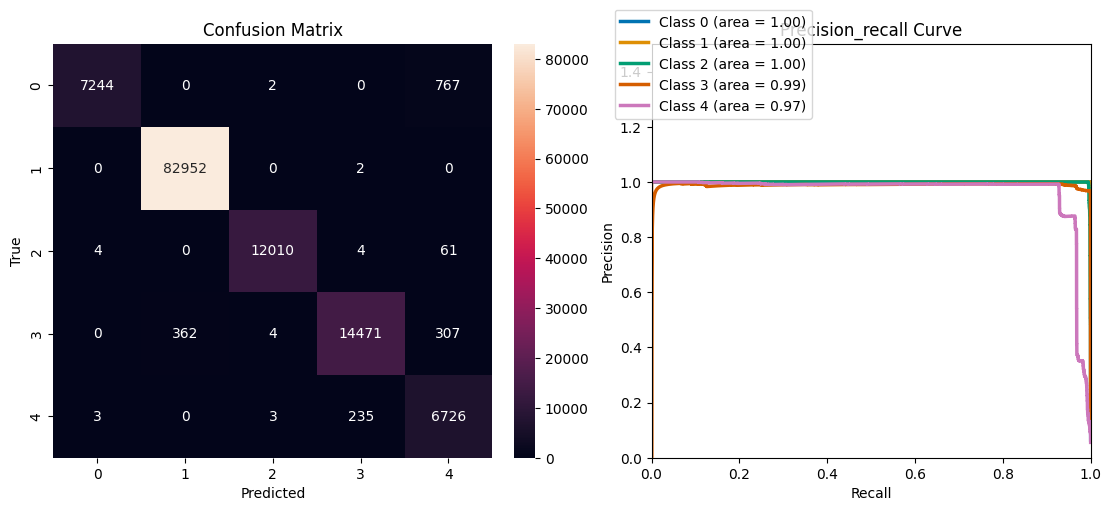

In [ ]:
print_metrics(metrics, conf_mat, precision_recall)

### LDA Only - Without Cross Validation

#### Category classification with Subcategory LDA components

In [ ]:
print("Training model with Subcategory LDA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(lda_features_subcategory, df['Cat'])
metrics_lda_subcategories_m=metrics

Training model with Subcategory LDA features..


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
metrics

{'type': 'train-test',
 'n_classes': 5,
 'accuracy': 98.71,
 'fit_time': 126772,
 'predict_time': 43,
 'misclassified': 1618,
 'precision_micro': 0.987,
 'precision_macro': 0.967,
 'precision_weighted': 0.988,
 'recall_micro': 0.987,
 'recall_macro': 0.966,
 'recall_weighted': 0.987,
 'f1_score_micro': 0.987,
 'f1_score_macro': 0.965,
 'f1_score_weighted': 0.987}

Accuracy: 97.23%
Precision
	Micro: 0.972
	Macro: 0.94
	Weighted: 0.973
Recall
	Micro: 0.972
	Macro: 0.914
	Weighted: 0.972
F1 score
	Micro: 0.972
	Macro: 0.924
	Weighted: 0.972
Fit time: 37328 ms
Predict time: 12 ms

Number of misclassified: 3464


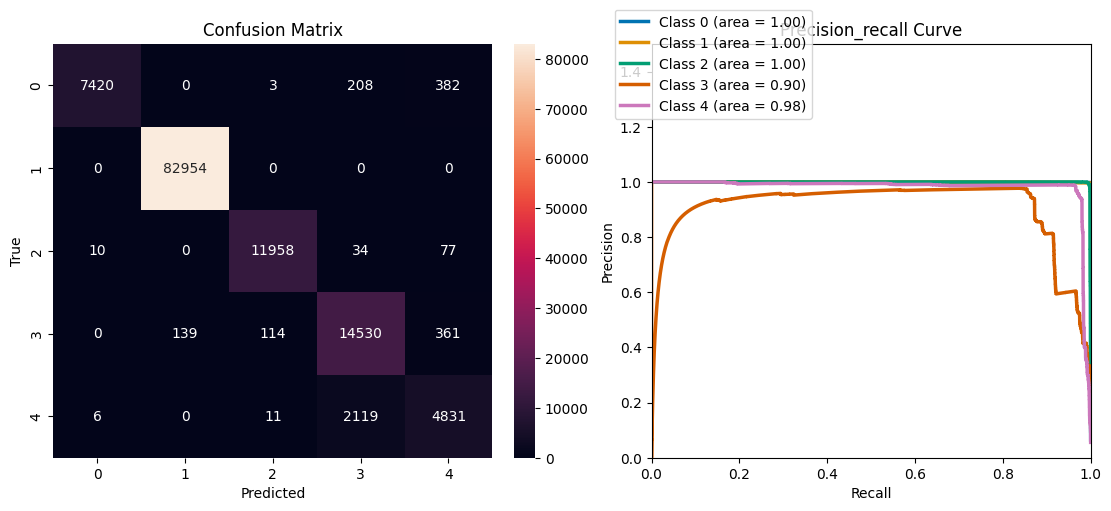

In [ ]:
print_metrics(metrics, conf_mat,precision_recall)

#### Category classification with Category LDA components

In [ ]:
print("Training model with Category LDA features..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(lda_features_category, df['Cat'])
metrics_lda_categoris_m=metrics

Training model with Category LDA features..


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 96.42%
Precision
	Micro: 0.964
	Macro: 0.962
	Weighted: 0.965
Recall
	Micro: 0.964
	Macro: 0.929
	Weighted: 0.964
F1 score
	Micro: 0.964
	Macro: 0.943
	Weighted: 0.963
Fit time: 23746 ms
Predict time: 15 ms

Number of misclassified: 4482


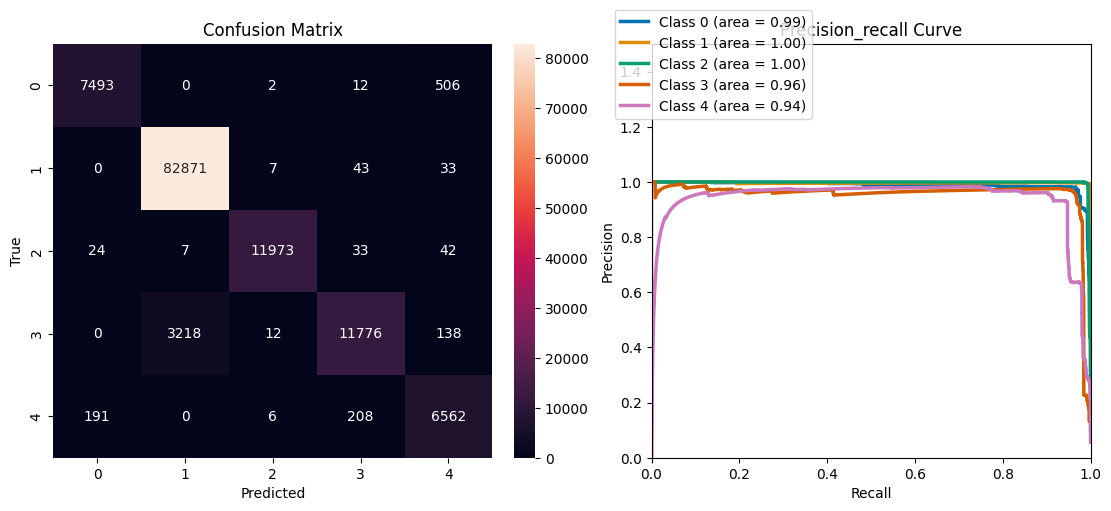

In [ ]:
print_metrics(metrics, conf_mat, precision_recall)

### LDA Only - With Cross Validation

#### Category classification with Category LDA components and Cross Validation

>



In [ ]:
print("Training model with Category LDA features and cross validation..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model_Kfold(lda_features_category, df['Cat'])
metrics_lda_categories_cross_m=metrics

Training model with Category LDA features and cross validation..


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 96.93%
Precision
	Micro: 0.969
	Macro: 0.952
	Weighted: 0.971
Recall
	Micro: 0.969
	Macro: 0.969
	Weighted: 0.969
F1 score
	Micro: 0.969
	Macro: 0.969
	Weighted: 0.969
Fit time: 129334 ms
Predict time: 14 ms

Number of misclassified: 3837


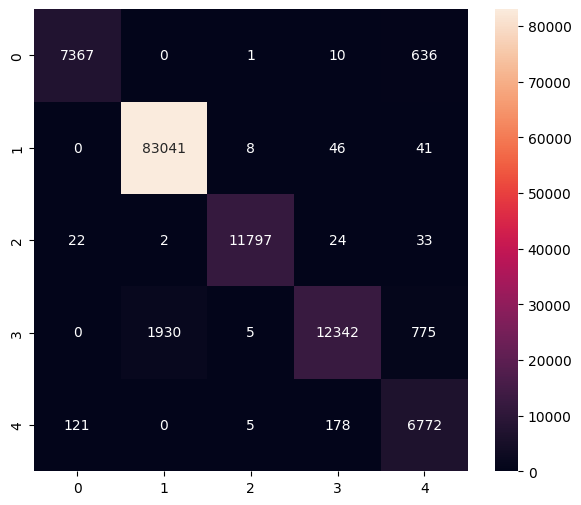

In [ ]:
print_metrics(metrics, conf_mat, precision_recall)

By trying to use Cross Validation, Category LDA is the only model where we can notice an improve in accuracy. However, fit time also increaded due to using cross validation.

### Combining PCA and LDA

#### First 11 components (best from skree plot)

#### Category Classification with 11 PCA components and LDA using Subcategory column

In [ ]:
pca_lda_data = perform_pca_lda(y=df['Sub_Cat'], n_components=11)
print_pca_lda_results(pca_lda_data)

Shape of transformed data: (625783, 8)
Transformed data:
[[-3.31627774e+00 -2.27638124e-01  1.04547214e+00 ...  3.82284916e-01
   5.16517089e-02  2.23804095e-01]
 [ 1.89471512e+01  8.17870808e+00 -3.85282212e-01 ...  1.06499609e-01
  -5.10539471e-01  3.40230521e-01]
 [ 1.76291354e+00 -2.44166966e+00 -1.77245697e+00 ...  1.45901956e+00
  -3.41832118e-01  5.60595791e-01]
 ...
 [ 1.43887907e+00 -2.12556305e+00 -1.58492596e+00 ...  2.27970187e-01
  -1.24678601e+00  3.68358287e-01]
 [ 1.22808230e+01 -8.13801200e+00 -3.47376636e-01 ...  5.18321542e-01
   7.96877557e-01  7.12016866e-02]
 [-3.20706562e+00 -3.87137872e-01  1.42156652e+00 ...  7.27083799e-01
   8.03523801e-03  6.29109748e-01]]


In [ ]:
print("Training model with 11 PCA features and Subcategory LDA..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(pca_lda_data, df['Cat'])
metrics_pca11_subcategories_m=metrics

Training model with 11 PCA features and Subcategory LDA..


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 96.49%
Precision
	Micro: 0.965
	Macro: 0.919
	Weighted: 0.976
Recall
	Micro: 0.965
	Macro: 0.929
	Weighted: 0.965
F1 score
	Micro: 0.965
	Macro: 0.914
	Weighted: 0.967
Fit time: 55792 ms
Predict time: 32 ms

Number of misclassified: 4396


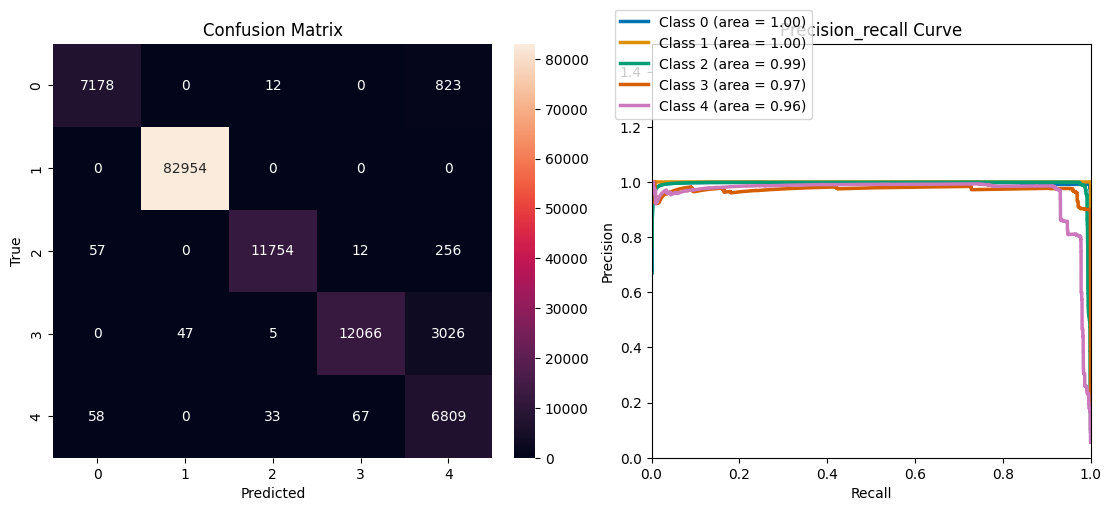

In [ ]:
print_metrics(metrics, conf_mat, precision_recall)

#### Category Classification with 11 PCA components and LDA using Category column

In [ ]:
pca_lda_data = perform_pca_lda(y=df['Cat'], n_components=11)
print_pca_lda_results(pca_lda_data)

Shape of transformed data: (625783, 4)
Transformed data:
[[  2.244625     1.41341166  -0.85230665   1.18634375]
 [-15.83667788   0.96214886   0.06575718   0.17804244]
 [  0.55278662  -2.73089669   1.87146541  -0.88617961]
 ...
 [  0.46289409  -2.50131052   0.48345852  -1.15155737]
 [  0.20774996  -6.26616587  -1.08879648   0.73286773]
 [  2.46149641   1.66264118  -0.63563501   1.73283945]]


In [ ]:
print("Training model with 11 PCA features and Subcategory LDA..")
classifier, metrics, conf_mat, precision_recall = train_LinearSVC_Model(pca_lda_data, df['Cat'])
metrics_pca11_categories_m=metrics

Training model with 11 PCA features and Subcategory LDA..


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 95.38%
Precision
	Micro: 0.954
	Macro: 0.948
	Weighted: 0.955
Recall
	Micro: 0.954
	Macro: 0.908
	Weighted: 0.954
F1 score
	Micro: 0.954
	Macro: 0.923
	Weighted: 0.952
Fit time: 19659 ms
Predict time: 21 ms

Number of misclassified: 5782


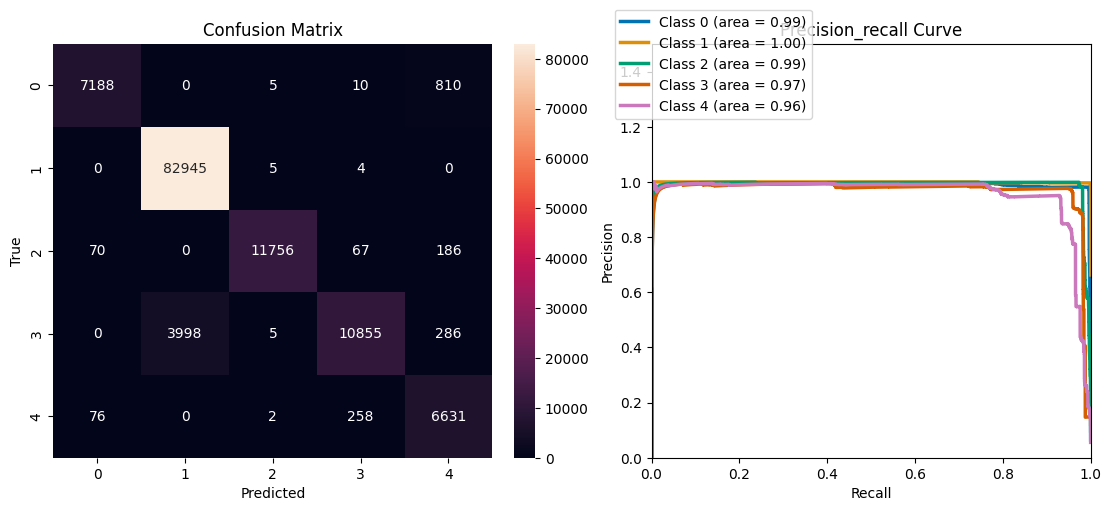

In [ ]:
print_metrics(metrics, conf_mat, precision_recall)

We can see that PCA doesn't affect the performance of Subcategory LDA, but improves the performance of Category LDA.

By experimenting with different PCA values, we can see that increasing the number of components would give higher accuracy but also higher training time, and decreasing the number of components would give smaller training time but worse accuracy. 11 components is the ideal balance between accuracy and fit time.

In [ ]:
metrics_data_m = {
    "Model": ["Classification with Subcategory LDA components", "Classification with Category LDA components", "Category classification with LDA and Cross Validation",
              "Classification with 11 PCA components and LDA using Subcategory", " Classification with 11 PCA components and LDA using Category"],
}

# metrics to include
metrics_to_include_m = ['accuracy', 'precision_macro', 'recall_macro', 'f1_score_macro', 'fit_time', 'predict_time']

# add metrics to metrics_data dictionary
for metric in metrics_to_include_m:
    metrics_data_m[metric.capitalize()] = [globals().get(f"metrics_{name}")[metric] for name in ['lda_subcategories_m', 'lda_categoris_m', 'lda_categories_cross_m', 'pca11_subcategories_m', 'pca11_categories_m']]

df_metrics_m = pd.DataFrame(metrics_data_m)



In [ ]:
df_metrics_m.columns.tolist()

['Model',
 'Accuracy',
 'Precision_macro',
 'Recall_macro',
 'F1_score_macro',
 'Fit_time',
 'Predict_time']

In [ ]:
# draw comparaison table
df_metrics_m.sort_values(by="Accuracy", ascending=False, inplace=True)
comparison_table = df_metrics_m.style.background_gradient(cmap='YlOrBr').set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'neon',
    'font-size': '15px'
})
comparison_table

,Model,Accuracy,Precision_macro,Recall_macro,F1_score_macro,Fit_time,Predict_time
0,Classification with Subcategory LDA components,97.230000,0.940000,0.914000,0.924000,37328,12
1,Classification with Category LDA components,97.060000,0.938000,0.940000,0.934000,42100,35
2,Category classification with LDA and Cross Validation,96.930000,0.952000,0.969000,0.969000,129334,14
3,Classification with 11 PCA components and LDA using Subcategory,96.490000,0.919000,0.929000,0.914000,55792,32
4,Classification with 11 PCA components and LDA using Category,95.380000,0.948000,0.908000,0.923000,19659,21


In [ ]:
# Drop two models with smallest balanced accuracy
# Get index of rows
dropped_rows_indices = df_metrics_m.tail(1).index.tolist()

dropped_rows = df_metrics_m.loc[dropped_rows_indices]  # Access rows by index list

print("Dropped rows:")
print(dropped_rows.to_string())  # Print dropped rows as string for better formatting

# Remove rows
new_df = df_metrics_m.iloc[:-1]

comparison_table = new_df[['Model','Accuracy']].style.background_gradient(cmap='GnBu').set_properties(**{
  'font-family': 'Lucida Calligraphy',
  'color': 'neon',
  'font-size': '15px'
})

print("\nComparison Table:")
comparison_table


Dropped rows:
                                                           Model  Accuracy  Precision_macro  Recall_macro  F1_score_macro  Fit_time  Predict_time
4   Classification with 11 PCA components and LDA using Category     95.38            0.948         0.908           0.923     19659            21

Comparison Table:


,Model,Accuracy
0,Classification with Subcategory LDA components,97.230000
1,Classification with Category LDA components,97.060000
2,Category classification with LDA and Cross Validation,96.930000
3,Classification with 11 PCA components and LDA using Subcategory,96.490000


In [ ]:
df_metrics_m['Accuracy'] /= 100

data_list = []

# Iterate over each row in the original DataFrame and append the transformed data
for index, row in new_df.iterrows():
    model = row['Model']
    accuracy = row['Accuracy']
    precision= row['Precision_macro']
    recall = row['Recall_macro']
    f1_score=row['F1_score_macro']

    data_list.append({'Model': model, 'Measures': 'Accuracy', 'Scores': accuracy	})

    data_list.append({'Model': model, 'Measures': 'Precision', 'Scores': precision})

    data_list.append({'Model': model, 'Measures': 'Recall', 'Scores': recall})

    data_list.append({'Model': model, 'Measures': 'F1_Score', 'Scores': f1_score})


df_transformed = pd.DataFrame(data_list)
df_transformed = df_transformed.sort_values(by=['Measures', 'Model']).reset_index(drop=True)


df_transformed

,Model,Measures,Scores
0,Category classification with LDA and Cross Val...,Accuracy,0.9693
1,Classification with 11 PCA components and LDA ...,Accuracy,0.9649
2,Classification with Category LDA components,Accuracy,0.9706
3,Classification with Subcategory LDA components,Accuracy,0.9723
4,Category classification with LDA and Cross Val...,F1_Score,0.9690
5,Classification with 11 PCA components and LDA ...,F1_Score,0.9140
6,Classification with Category LDA components,F1_Score,0.9340
7,Classification with Subcategory LDA components,F1_Score,0.9240
8,Category classification with LDA and Cross Val...,Precision,0.9520
9,Classification with 11 PCA components and LDA ...,Precision,0.9190


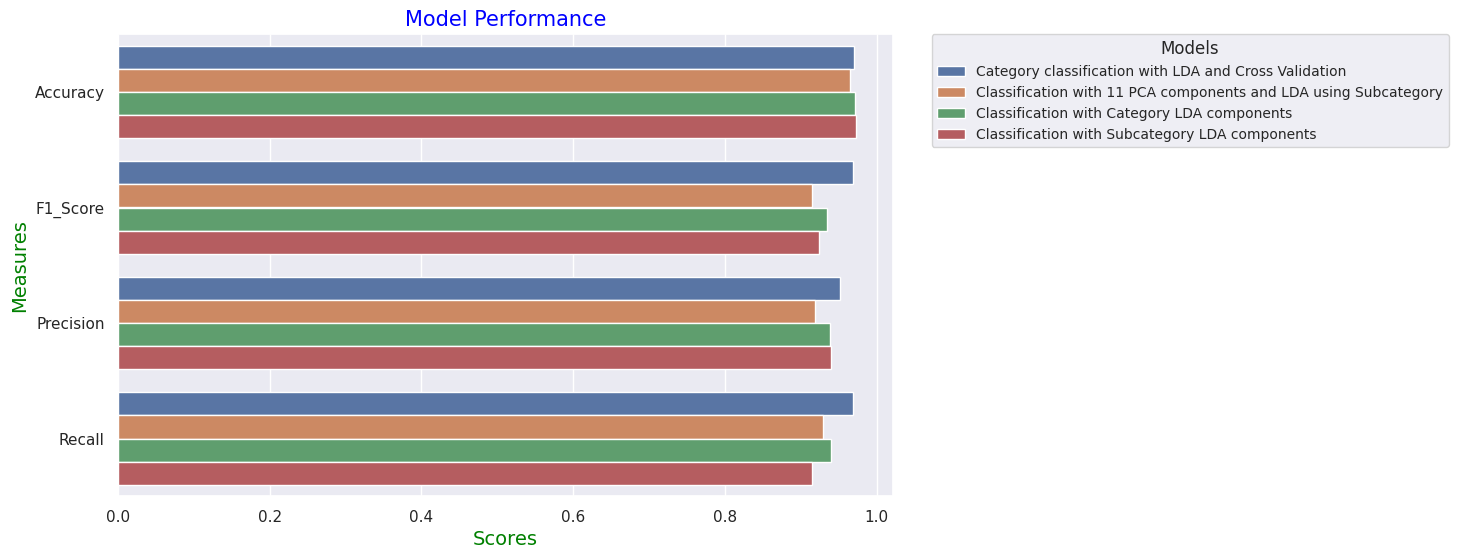

In [ ]:
sns.set(rc={"figure.figsize":(10, 6)})

sns.barplot(data=df_transformed, y='Measures', x='Scores', hue='Model')

plt.title('Model Performance', fontdict={'fontsize': 15, 'color': 'blue'})
plt.xlabel('Scores', fontdict={'fontsize': 14, 'color': 'green'})
plt.ylabel('Measures', fontdict={'fontsize': 14, 'color': 'green'})

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='10', title='Models')
plt.show()

In [ ]:
# Define the model value to drop
model_to_drop = "Classification with 11 PCA components and LDA using Subcategory"

filtered_df = new_df.drop(new_df[new_df["Model"] == model_to_drop].index)

filtered_df


,Model,Accuracy,Precision_macro,Recall_macro,F1_score_macro,Fit_time,Predict_time
0,Classification with Subcategory LDA components,0.9723,0.940,0.914,0.924,37328,12
1,Classification with Category LDA components,0.9706,0.938,0.940,0.934,42100,35
2,Category classification with LDA and Cross Val...,0.9693,0.952,0.969,0.969,129334,14


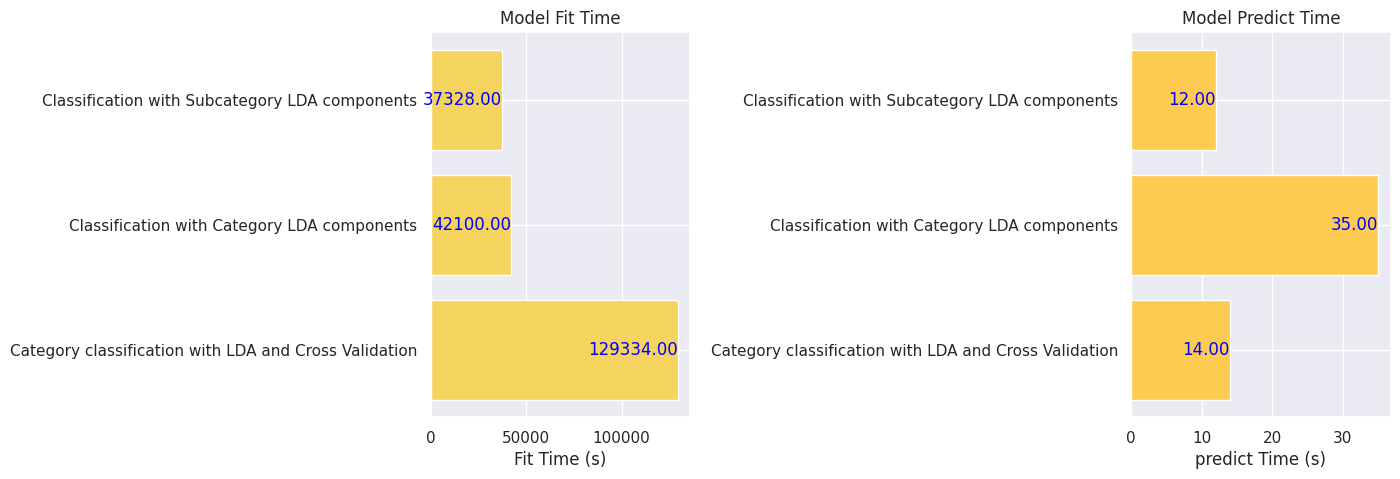

In [ ]:
import matplotlib.pyplot as plt

classifiers = filtered_df['Model']
Fit_time = filtered_df['Fit_time']


classifiers2 = filtered_df['Model']
Predict_time2 = filtered_df['Predict_time']



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

y = range(len(classifiers))


bars1 = ax1.barh(y, Fit_time, color='#f4d35e')

ax1.set_xlabel('Fit Time (s)')
ax1.set_title('Model Fit Time')
ax1.set_yticks(y)
ax1.set_yticklabels(classifiers)
ax1.invert_yaxis()  # Labels read top-to-bottom

for bar in bars1:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width - 0.05
    ax1.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             va='center', ha='right' if width > 0 else 'left', color='blue')


bars2 = ax2.barh(y, Predict_time2, color='#fecb52')

ax2.set_xlabel('predict Time (s)')
ax2.set_title('Model Predict Time')
ax2.set_yticks(y)
ax2.set_yticklabels(classifiers2)
ax2.invert_yaxis()

for bar in bars2:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width - 0.05
    ax2.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             va='center', ha='right' if width > 0 else 'left', color='blue')

plt.subplots_adjust(left=0.1, right=0.9, wspace=1.7)

plt.show()


##After observing the plot of Fit time and We can Conclude that Classification with Subcategory LDA components is the best ##